# SVI for Poisson RGG

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
sys.path.append('../../utils')

In [3]:
from graphs import (get_independent_components_rgg, make_inter_vertex_distances, 
                    deg_corrected_poissonian_random_geometric_graph)

In [4]:
from plot import plot_multigraph
from networkx.linalg.graphmatrix import adjacency_matrix
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import math
from time import time
import pandas as pd

In [5]:
SEED = 42
n = 10
dim = 2

In [6]:
lambda_r_truth = 2
exponential_kernel = lambda dist, ki, kj: ki * kj * math.exp(-lambda_r_truth * dist)

In [7]:
kolness_truth = np.ones(n)
kolness_truth[0] = 10

In [8]:
r = np.random.RandomState(SEED)
G_poisson = deg_corrected_poissonian_random_geometric_graph(
    n, 1000, kolness_truth, exponential_kernel, r, 
)

In [9]:
adj = adjacency_matrix(G_poisson)
adj = adj.toarray()

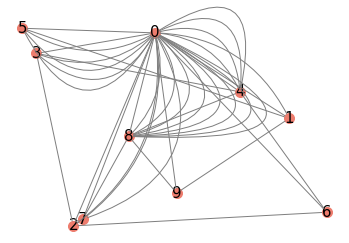

In [10]:
ax = plot_multigraph(G_poisson)

In [11]:
distances = make_inter_vertex_distances(G_poisson)

## Inference

In [12]:
import pyro.distributions as dist
import pyro
from torch.distributions import constraints
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO
import torch

In [13]:
distances = torch.tensor(distances)
distances

tensor([[0.0000, 0.5017, 0.8242, 0.3276, 0.3320, 0.3545, 0.8688, 0.7911, 0.4317,
         0.6620],
        [0.5017, 0.0000, 0.7264, 0.7251, 0.1706, 0.8025, 0.3992, 0.6893, 0.4341,
         0.4296],
        [0.8242, 0.7264, 0.0000, 0.7169, 0.7092, 0.8251, 0.6788, 0.0376, 0.3974,
         0.3073],
        [0.3276, 0.7251, 0.7169, 0.0000, 0.5656, 0.1103, 1.0135, 0.6939, 0.4209,
         0.6858],
        [0.3320, 0.1706, 0.7092, 0.5656, 0.0000, 0.6368, 0.5471, 0.6716, 0.3489,
         0.4499],
        [0.3545, 0.8025, 0.8251, 0.1103, 0.6368, 0.0000, 1.1104, 0.8029, 0.5278,
         0.7936],
        [0.8688, 0.3992, 0.6788, 1.0135, 0.5471, 1.1104, 0.0000, 0.6513, 0.6137,
         0.4082],
        [0.7911, 0.6893, 0.0376, 0.6939, 0.6716, 0.8029, 0.6513, 0.0000, 0.3626,
         0.2724],
        [0.4317, 0.4341, 0.3974, 0.4209, 0.3489, 0.5278, 0.6137, 0.3626, 0.0000,
         0.2662],
        [0.6620, 0.4296, 0.3073, 0.6858, 0.4499, 0.7936, 0.4082, 0.2724, 0.2662,
         0.0000]], dtype=tor

In [14]:
adj = torch.tensor(adj)
adj

tensor([[0, 2, 2, 3, 5, 4, 1, 3, 9, 1],
        [2, 0, 0, 0, 0, 1, 0, 0, 0, 1],
        [2, 0, 0, 1, 0, 0, 1, 2, 0, 0],
        [3, 0, 1, 0, 1, 0, 0, 0, 0, 0],
        [5, 0, 0, 1, 0, 0, 1, 0, 1, 0],
        [4, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 1, 0, 1, 0, 0, 0, 0, 0],
        [3, 0, 2, 0, 0, 0, 0, 0, 1, 0],
        [9, 0, 0, 0, 1, 0, 0, 1, 0, 1],
        [1, 1, 0, 0, 0, 0, 0, 0, 1, 0]])

$$P(G|D, \theta, k) = \prod_{i<j} \frac{(k_i k_j \mathcal{F}(D_{ij}, \theta))^{A_{ij}}}{A_{ij}!} \exp(- k_i k_j \mathcal{F}(D_{ij}, \theta))$$

In [15]:
g = dist.Gamma(1,0.1)

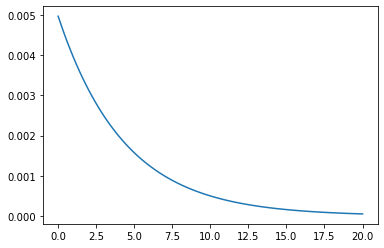

In [16]:
x = np.linspace(0.01,20,100)
plt.plot(x, 10**g.log_prob(x))

In [107]:
def dc_poisson_rgg_model(distances, adj):
    n_nodes = adj.shape[0]
    k = pyro.sample("kolness", dist.Exponential(0.1).expand([n_nodes]).to_event(1))  # tell pyro that these are all dependent variables
    lambda_r = pyro.sample("lambda_r", dist.Exponential(0.1))
    conn_kernel = torch.exp(-lambda_r*distances)
    
    assert k.shape == (n_nodes,)
    assert conn_kernel.shape == (n_nodes, n_nodes)
    
    r, c = torch.triu_indices(n_nodes, n_nodes, offset=1)    
    
    for i in pyro.plate("data_loop", len(r)):
        rate_i = k[r[i]]*k[c[i]]*conn_kernel[r[i],c[i]]
        pyro.sample(f"obs_{i}", dist.Poisson(rate_i), obs=adj[r[i],c[i]]) 


## Exact inference

In [18]:
import arviz as az
from pyro.infer import MCMC, NUTS

In [19]:
nuts_kernel = NUTS(dc_poisson_rgg_model)

In [20]:
mcmc = MCMC(nuts_kernel, num_samples=1000, warmup_steps=100, num_chains=4)

Warmup [1]:   0%|          | 0/1100 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/1100 [00:00, ?it/s]

Warmup [3]:   0%|          | 0/1100 [00:00, ?it/s]

Warmup [4]:   0%|          | 0/1100 [00:00, ?it/s]

In [21]:
mcmc.run(distances, adj)

In [22]:
inferred = az.from_pyro(mcmc)

/home/juvid/miniconda3/envs/kolgraph_pyro/lib/python3.9/site-packages/arviz/data/io_pyro.py:157: UserWarning: Could not get vectorized trace, log_likelihood group will be omitted. Check your model vectorization or set log_likelihood=False
  warnings.warn(


In [23]:
summary = az.summary(inferred) # , var_names = ['lambda_r', 'kolness']
summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
kolness[0],14.122,4.874,5.622,22.869,0.094,0.066,2610.0,2474.0,1.0
kolness[1],0.999,0.502,0.239,1.916,0.008,0.006,3950.0,2545.0,1.0
kolness[2],1.837,0.845,0.477,3.355,0.015,0.011,3291.0,2905.0,1.0
kolness[3],0.906,0.405,0.267,1.672,0.006,0.004,4887.0,2813.0,1.0
kolness[4],1.305,0.483,0.441,2.162,0.007,0.005,4428.0,2993.0,1.0
kolness[5],1.034,0.462,0.264,1.843,0.007,0.005,3871.0,2535.0,1.0
kolness[6],1.878,1.260,0.205,4.089,0.024,0.017,2599.0,2481.0,1.0
kolness[7],1.626,0.701,0.508,2.934,0.011,0.008,4276.0,3247.0,1.0
kolness[8],2.233,0.763,0.909,3.617,0.012,0.009,3679.0,2548.0,1.0
kolness[9],0.810,0.467,0.133,1.670,0.008,0.005,3459.0,2701.0,1.0


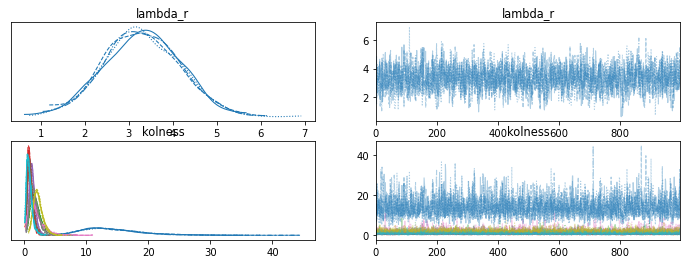

In [24]:
az.plot_trace(inferred, var_names = ['lambda_r', 'kolness']);

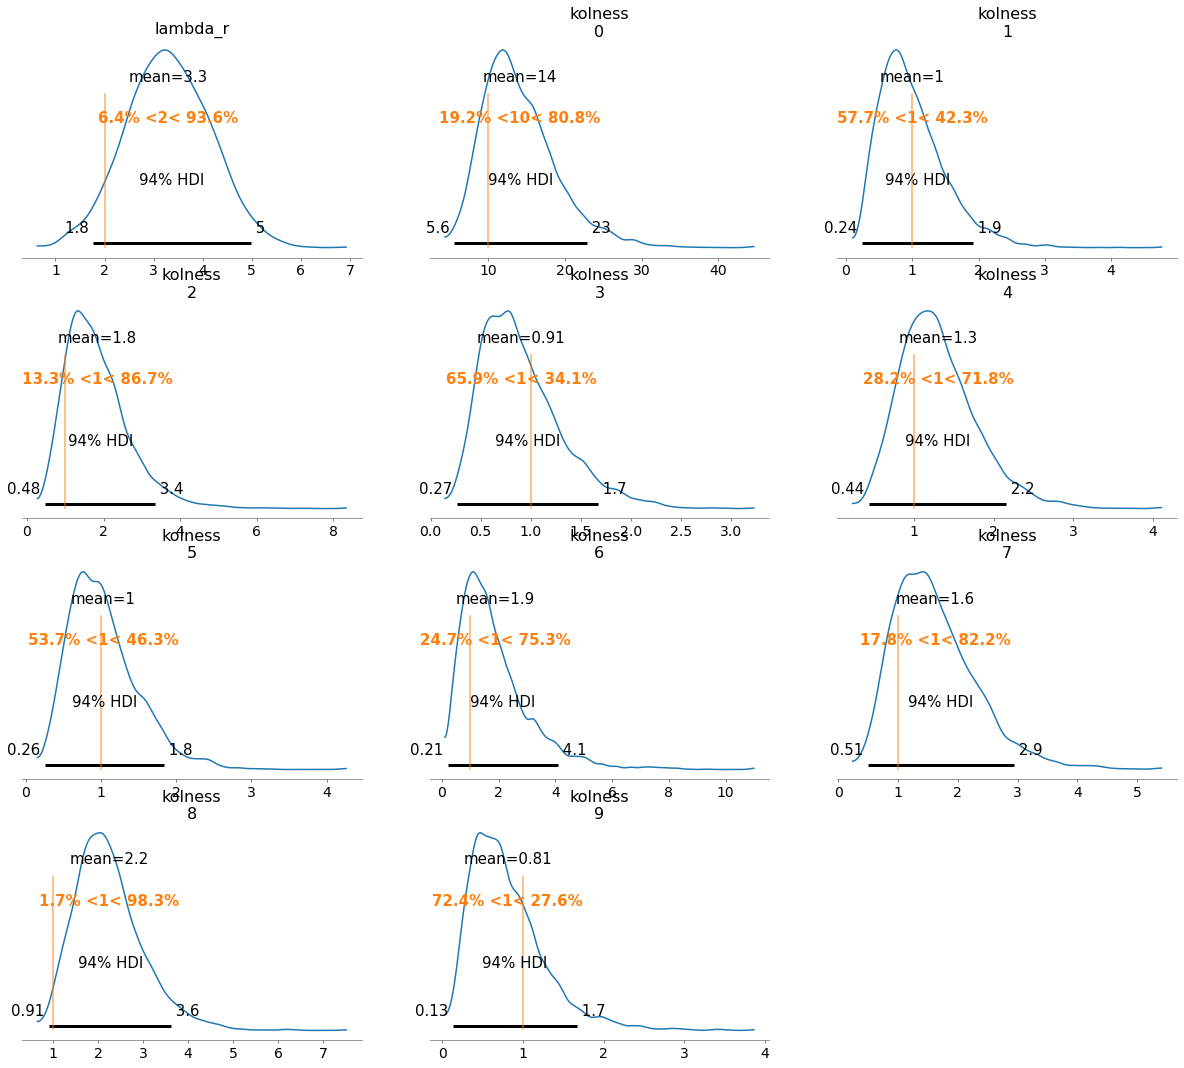

In [25]:
az.plot_posterior(inferred, var_names = ['lambda_r', 'kolness'], ref_val = [lambda_r_truth] + list(kolness_truth));

In [26]:
az.to_netcdf(inferred, 'pyro-poisson-rgg.netcdf')

'pyro-poisson-rgg.netcdf'

In [ ]:
inferred = az.from_netcdf('pyro-poisson-rgg.netcdf')

## MAP estimation

In [78]:
from pyro.infer.autoguide import AutoDelta

In [79]:
# def dc_poisson_rgg_guide_map(distances, adj):    
#     n_nodes = adj.shape[0]
#     kolness_map = pyro.param("kolness_map", torch.tensor(1).expand([n_nodes]), constraint=constraints.positive).to_event(1)
#     lambda_r_map = pyro.param("lambda_r_map", torch.tensor(1), constraint=constraints.positive)
#     kolness = pyro.sample("kolness", dist.Delta(kolness_map))
#     lambda_r = pyro.sample("lambda_r", dist.Delta(lambda_r_map))

dc_poisson_rgg_guide_map = AutoDelta(dc_poisson_rgg_model)
    

In [80]:
def train(model, guide, data, lr=0.01, n_steps=1000):
    pyro.clear_param_store()
    adam = pyro.optim.Adam({"lr": lr})
    svi = SVI(model, guide, adam, loss=Trace_ELBO())
    
    losses = []
    for step in range(n_steps):
        loss = svi.step(**data)
        losses.append(loss)
        if step % 100 == 0:
            print('[iter {}]  loss: {:.4f}'.format(step, loss))
    
    return losses

In [81]:
data = {'distances':distances, 'adj': adj}

In [82]:
losses = train(dc_poisson_rgg_model, dc_poisson_rgg_guide_map, data)

[iter 0]  loss: 169.9346
[iter 100]  loss: 88.6698
[iter 200]  loss: 75.3882
[iter 300]  loss: 69.5292
[iter 400]  loss: 66.7051
[iter 500]  loss: 65.3482
[iter 600]  loss: 64.6903
[iter 700]  loss: 64.3627
[iter 800]  loss: 64.1941
[iter 900]  loss: 64.1047


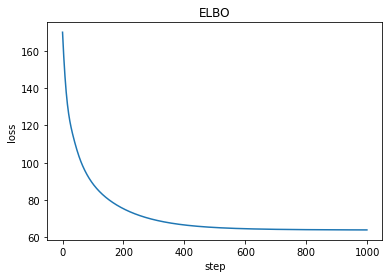

In [83]:
fig, ax = plt.subplots()
ax.plot(losses)
ax.set_title("ELBO")
ax.set_xlabel("step")
ax.set_ylabel("loss");

In [87]:
for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name))

AutoDelta.kolness tensor([9.9041, 0.5978, 1.1847, 0.6287, 0.9833, 0.6901, 0.7272, 1.1230, 1.6208,
        0.4614], grad_fn=<AddBackward0>)
AutoDelta.lambda_r tensor(1.8938, grad_fn=<AddBackward0>)


In [102]:
map_estimate = pd.DataFrame(zip(pyro.param('AutoDelta.kolness').tolist(), kolness_truth), columns=['MAP', 'truth'])
map_estimate

,MAP,truth
0,9.904140,10.0
1,0.597818,1.0
2,1.184670,1.0
3,0.628653,1.0
4,0.983333,1.0
5,0.690147,1.0
6,0.727246,1.0
7,1.122956,1.0
8,1.620839,1.0
9,0.461401,1.0


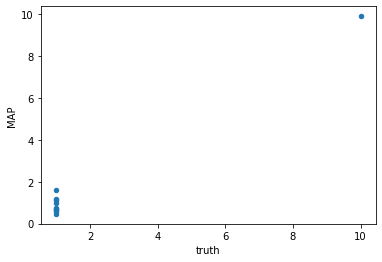

In [106]:
ax = map_estimate.plot(x='truth', y='MAP', kind='scatter');

---

## Full SVI -- experimental

In [ ]:
def dc_poisson_rgg_guide(distances, adj):
    n_nodes = adj.shape[0]
    k = pyro.sample("kolness", dist.Gamma(1., 0.1).expand([n_nodes]).to_event(1))  # tell pyro that these are all dependent variables
    lambda_r = pyro.sample("lambda_r", dist.Gamma(1., 0.1))    

In [32]:
adam = pyro.optim.Adam({'lr': 0.001})
svi = SVI(dc_poisson_rgg_model, dc_poisson_rgg_guide, adam, loss=Trace_ELBO())

In [33]:
r, _ = torch.triu_indices(adj.shape[0], adj.shape[0])
n_data = len(r)

In [34]:
n_steps = 1000
losses = []

pyro.clear_param_store()
for j in range(n_steps):
    loss = svi.step(distances, adj)
    losses.append(loss)
    if j % 100 == 0:
        print(f"[iteration{j+1: 04d}] loss: {loss/n_data:.4f}")

[iteration 001] loss: 7.8988
[iteration 101] loss: 9.5879
[iteration 201] loss: 3.7309
[iteration 301] loss: 20.1723
[iteration 401] loss: 53.2543
[iteration 501] loss: 14.7498
[iteration 601] loss: 30.9007
[iteration 701] loss: 8.7479
[iteration 801] loss: 8.1331
[iteration 901] loss: 8.0737


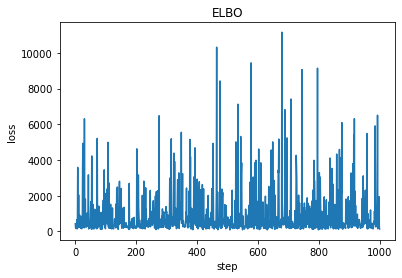

In [35]:
fig, ax = plt.subplots()
ax.plot(losses)
ax.set_title("ELBO")
ax.set_xlabel("step")
ax.set_ylabel("loss");